# Problema #2: Prognozuoti ar e.recepte išrašytas vaistas bus įsigytas

Problema: Ar pagal turimus duomenis iš atviru e receptų archyvo, galima numatyti kurie receptai nebus isigyti pacientų. 



 - Naudojamos bibliotekos 

In [76]:
import csv
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
from tabulate import tabulate
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

!pip install html5lib



!pip install --upgrade scikit-learn

You should consider upgrading via the 'C:\Users\mazei\PycharmProjects\ML2\venv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\mazei\PycharmProjects\ML2\venv\Scripts\python.exe -m pip install --upgrade pip' command.


- Projektui atlikti buvo pasimti 2022 metu sausio menesio duomenys 
- Kadangi turimi duomenys yra atskirit pagal menesio dekadas, naudojama map funkcija kartu su glob.glob funkcija, padedancia sukelti kelis failus pagal nurodyta path'a i viena dataframe'a 

In [2]:
path = 'receptai'
csv_files = glob.glob(path + "/*.csv")

df_rec = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv"))) 

C:\Users\mazei\AppData\Local\Temp\ipykernel_20788\2054624597.py:4: DtypeWarning: Columns (18,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_rec = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv")))
C:\Users\mazei\AppData\Local\Temp\ipykernel_20788\2054624597.py:4: DtypeWarning: Columns (18,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_rec = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv")))
C:\Users\mazei\AppData\Local\Temp\ipykernel_20788\2054624597.py:4: DtypeWarning: Columns (18,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_rec = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv")))


- patogumui, sumapintas bendras dataframe'as isaugomas kaip csv failas projekto direktorijoje 

In [3]:
df_rec.to_csv('df_rec.csv', index=False)

- Susipazinimas su duomenimis. 
Unikalios reiksmes - dirbt_recepto_id (unikalus recepto numeris)
Tos pacios  reiksmes visam dataframe'e - recepto_metai, recepto_ketv (visi duomenys yra 2022 metu pirmo ketvircio - tiksliau- sausio)

In [4]:
df_rec.head()

,dirbt_recepto_id,recepto_metai,recepto_ketv,ligos_kodas,ligos_pav,vaisto_tipas,vaisto_bendr_pav,vaisto_prek_pav,atc_kodas,atc_pav,...,recepto_galiojimas_d,kompens_poz,vaisto_narkot_poz_id,vaisto_narkot_poz_pav,recepto_statusas,org_savivaldybe,gyd_kvalifikacijos_galioja,pac_lytis,pac_amziaus_gr,pac_savivaldybe
0,49569155866232409,2022,1,I11.9,Hipertenzinė širdies liga be širdies nepakanka...,Vaistas,tert-butilamino perindoprilis/Indapamidas,NaN,C09BA04,Perindopril and diuretics,...,29,1,NaN,NaN,completed,Kauno m. sav.,"Medicinos gydytojas, Šeimos gydytojas",M,Nuo 65 m.,Kauno m. sav.
1,49559872754121867,2022,1,J42,Nepatikslintas lėtinis bronchitas,Vaistas,Azitromicinas,NaN,J01FA10,Azithromycin,...,29,0,NaN,NaN,completed,Zarasų r. sav.,Šeimos gydytojas,M,Nuo 65 m.,Zarasų r. sav.
2,49572472626200619,2022,1,I11.9,Hipertenzinė širdies liga be širdies nepakanka...,Vaistas,Telmisartanas/Hidrochlorotiazidas,NaN,C09DA07,Telmisartan and diuretics,...,9,1,NaN,NaN,stopped,Klaipėdos m. sav.,Gydytojas kardiologas,M,45-64 m.,Klaipėdos m. sav.
3,49560291849435611,2022,1,I11.0,Hipertenzinė širdies liga su širdies nepakanka...,Vaistas,Bizoprololis/Amlodipinas,NaN,C07FB07,Bisoprolol and amlodipine,...,29,1,NaN,NaN,completed,Klaipėdos m. sav.,Šeimos gydytojas,M,Nuo 65 m.,Klaipėdos m. sav.
4,49567330815026997,2022,1,I11.9,Hipertenzinė širdies liga be širdies nepakanka...,Vaistas,tert-butilamino perindoprilis/Amlodipinas,NaN,C09BB04,Perindopril and amlodipine,...,29,1,NaN,NaN,completed,Jonavos r. sav.,Šeimos gydytojas,M,Nuo 65 m.,Jonavos r. sav.


- is pirmo zvilgsnio, vaisto_tipas atrodo tas pats, taciau patikrinama kokios dar reiksmes egzistuoja stulpelyje. Pagrindine ir didziausia klase - Vaistas, taip pat pastebima kad stulpelyje yra 'Neatveriama' reikšmių. tai receptai kurie yra papildomai užslaptinti ir ju duomenys nepatenka į viešuma. 

In [4]:
df_rec['vaisto_tipas'].value_counts()

Vaistas                           1389723
Medicininos pagalbos priemonės      55958
Neatveriama                          4065
Ekstemporalus vaistas                 924
Vardinis vaistas                      908
Name: vaisto_tipas, dtype: int64

- Patikrinkimas kokie stulpeliai su kokiais tipais egzistuoja lenteleje 

In [5]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451578 entries, 0 to 465104
Data columns (total 36 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   dirbt_recepto_id            1451578 non-null  int64  
 1   recepto_metai               1451578 non-null  int64  
 2   recepto_ketv                1451578 non-null  int64  
 3   ligos_kodas                 1451578 non-null  object 
 4   ligos_pav                   1451578 non-null  object 
 5   vaisto_tipas                1451578 non-null  object 
 6   vaisto_bendr_pav            1450158 non-null  object 
 7   vaisto_prek_pav             34844 non-null    object 
 8   atc_kodas                   1392679 non-null  object 
 9   atc_pav                     1392679 non-null  object 
 10  vaisto_farmac_forma_id      1395511 non-null  float64
 11  vaisto_farmac_forma_pav     1395511 non-null  object 
 12  vaisto_stiprumas            1395209 non-null  object 
 13

- Patikrinkime, kiek visuose stulpeliuose turim null reiksmiu 

In [17]:
df_rec.isna().sum()

dirbt_recepto_id                    0
recepto_metai                       0
recepto_ketv                        0
ligos_kodas                         0
ligos_pav                           0
vaisto_tipas                        0
vaisto_bendr_pav                 1420
vaisto_prek_pav               1416734
atc_kodas                       58899
atc_pav                         58899
vaisto_farmac_forma_id          56067
vaisto_farmac_forma_pav         56067
vaisto_stiprumas                56369
mpp_aprasymas                 1430658
dozuociu_sk                         0
dozuociu_sk_vnt_id                  0
dozuociu_sk_vnt_pav                 0
vart_budas_id                 1447509
vart_budas_pav                1447509
vien_doze                     1447509
vien_doze_vnt_id              1447509
vien_doze_vnt_pav             1447509
vart_daznumas                 1447509
vart_laikas                   1447509
vart_trukme_d                       0
gydymui_testi_periodas_d      1427092
recepto_gali

- Trečdalis stulpeliu duomenyse yra su dauguma null reiksmiu. 
- Daugiausiai null reiksmiu yra apie vaisto vartojima (95 proc)
    -narkotines savybes (90 proc)
    -gydymo testinumo perioda ir vaisto prekini pavadinimą (95 proc)
- Sie stulpeliai nebus naudojami stebejimams, nes turi per mazai duomenu modeliui kokybiskai apsimokyti 

In [18]:
df_rec['vart_budas_pav'].value_counts()

Neatveriama          4065
vartoti per burną       4
Name: vart_budas_pav, dtype: int64

In [19]:
df_rec['vart_daznumas'].value_counts()

Neatveriama    4065
2 k./1 d.         3
1 k./1 d.         1
Name: vart_daznumas, dtype: int64

In [20]:
df_rec['vaisto_narkot_poz_pav'].value_counts()

Psichotropas                            115648
Narkotikas                               14188
Kompensuojamas tik tęstiniam gydymui      4877
Neatveriama                               4065
Prekursorius                                 3
Name: vaisto_narkot_poz_pav, dtype: int64

- kiek procentu visu reiksmiu sudaro reiksme "neatveriama"

In [21]:
value = 'Neatveriama'
total_rows = len(df_rec)

for column in df_rec.columns:
    value_count = df_rec[column].value_counts().get(value, 0)
    
value_count/total_rows * 100


2.3086599548904707

'Neatveriama' reikšmės visame dataframe'e uzima tik 2 procentus visų duomenų. tai nepakenks modeliui, daroma prielaida, kad gali net padėti - gal neatveriami duomenys yra užslaptinti dėl vaisto vartojimo ar ligos stiprumo specifikos, kas gali indikuoti vaisto isigyjimą

- Stulpeliu salinimas - Stulpeliai su daugiau nei 90 proc nulinemis reiksmemis bus šalinami, nes neduoda jokios pridedamosios vertas. Taip pat kaip pasikartojantys stulpeliai apie pavadinimus, unikalūs kodų stulpeliai,datos stulpeliai.

In [22]:
df_rec =df_rec.drop(['vaisto_prek_pav', 
         'atc_kodas', 
         'atc_pav', 
         'vaisto_farmac_forma_id',
         'vaisto_farmac_forma_pav',
         'mpp_aprasymas',
         'dozuociu_sk_vnt_id',
         'vart_budas_id',
        'vart_budas_pav',
        'vien_doze',
        'vien_doze_vnt_id',
        'vien_doze_vnt_pav',
        'vart_daznumas',
        'vart_laikas',
        'gydymui_testi_periodas_d',
        'vaisto_narkot_poz_id',
        'vaisto_narkot_poz_pav',
        'org_savivaldybe',
                     
        'dirbt_recepto_id', 
        'recepto_metai', 
        'recepto_ketv', 
        'ligos_pav',
        'dozuociu_sk_vnt_pav'], axis=1)

- Po stulpeliu isvalymo pasitikriname, kiek naudingu stulpeliu yra su null reiksmemis 

In [23]:
df_rec.isnull().sum()

ligos_kodas                        0
vaisto_tipas                       0
vaisto_bendr_pav                1420
vaisto_stiprumas               56369
dozuociu_sk                        0
vart_trukme_d                      0
recepto_galiojimas_d               0
kompens_poz                        0
recepto_statusas                   0
gyd_kvalifikacijos_galioja      1212
pac_lytis                        927
pac_amziaus_gr                   927
pac_savivaldybe               102608
dtype: int64

- Triname null reiksmes. po viso to, pasitikriname, ar tikrai visos null reiksmes yra pasalintos is duomenu rinkinio 

In [24]:
df_rec = df_rec[df_rec['vaisto_stiprumas'].replace(0, pd.NA).notna()]
df_rec = df_rec[df_rec['gyd_kvalifikacijos_galioja'].replace(0, pd.NA).notna()]
df_rec = df_rec[df_rec['pac_lytis'].replace(0, pd.NA).notna()]
df_rec = df_rec[df_rec['pac_amziaus_gr'].replace(0, pd.NA).notna()]
df_rec = df_rec[df_rec['pac_savivaldybe'].replace(0, pd.NA).notna()]


df_rec.isnull().sum()

ligos_kodas                   0
vaisto_tipas                  0
vaisto_bendr_pav              0
vaisto_stiprumas              0
dozuociu_sk                   0
vart_trukme_d                 0
recepto_galiojimas_d          0
kompens_poz                   0
recepto_statusas              0
gyd_kvalifikacijos_galioja    0
pac_lytis                     0
pac_amziaus_gr                0
pac_savivaldybe               0
dtype: int64

In [25]:
df_rec.head()

,ligos_kodas,vaisto_tipas,vaisto_bendr_pav,vaisto_stiprumas,dozuociu_sk,vart_trukme_d,recepto_galiojimas_d,kompens_poz,recepto_statusas,gyd_kvalifikacijos_galioja,pac_lytis,pac_amziaus_gr,pac_savivaldybe
0,I11.9,Vaistas,tert-butilamino perindoprilis/Indapamidas,"8 mg/2,5 mg",60,60,29,1,completed,"Medicinos gydytojas, Šeimos gydytojas",M,Nuo 65 m.,Kauno m. sav.
1,J42,Vaistas,Azitromicinas,500 mg,3,3,29,0,completed,Šeimos gydytojas,M,Nuo 65 m.,Zarasų r. sav.
2,I11.9,Vaistas,Telmisartanas/Hidrochlorotiazidas,"80 mg/12,5 mg",28,28,9,1,stopped,Gydytojas kardiologas,M,45-64 m.,Klaipėdos m. sav.
3,I11.0,Vaistas,Bizoprololis/Amlodipinas,5 mg/5 mg,60,60,29,1,completed,Šeimos gydytojas,M,Nuo 65 m.,Klaipėdos m. sav.
4,I11.9,Vaistas,tert-butilamino perindoprilis/Amlodipinas,8 mg/10 mg,90,90,29,1,completed,Šeimos gydytojas,M,Nuo 65 m.,Jonavos r. sav.


- pasitikriname, kokiu tipu yra like duomenu stulpeliai

In [26]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300704 entries, 0 to 465104
Data columns (total 13 columns):
 #   Column                      Non-Null Count    Dtype 
---  ------                      --------------    ----- 
 0   ligos_kodas                 1300704 non-null  object
 1   vaisto_tipas                1300704 non-null  object
 2   vaisto_bendr_pav            1300704 non-null  object
 3   vaisto_stiprumas            1300704 non-null  object
 4   dozuociu_sk                 1300704 non-null  int64 
 5   vart_trukme_d               1300704 non-null  int64 
 6   recepto_galiojimas_d        1300704 non-null  int64 
 7   kompens_poz                 1300704 non-null  int64 
 8   recepto_statusas            1300704 non-null  object
 9   gyd_kvalifikacijos_galioja  1300704 non-null  object
 10  pac_lytis                   1300704 non-null  object
 11  pac_amziaus_gr              1300704 non-null  object
 12  pac_savivaldybe             1300704 non-null  object
dtypes: int64(4), 

- Darant hipoteze, kad receptu issigyjimui itaka gali daryti vaisto populiarumas, uzsikeliame ir susitvarkome pardavimu lentele viešai prieinama VVKT tinklapyje
- Paimti duomenys yra apie 2022 metu sausio menesio pardavimus

In [28]:
csv_file = 'pardavimai/ParduotuvaistinemsirASPIvaistiniupreparatukiekis2022gruodisPatikslinta.xlsx'

df_pard = pd.read_excel(csv_file, sheet_name='Sheet1', usecols= ['Bendrinis pavadinimas', '2022 m. sausis'])

df_pard.head()


,Bendrinis pavadinimas,2022 m. sausis
0,NaN,NaN
1,Tiamino hidrochloridas/Piridoksino hidrochlori...,21279.0
2,Sulfametoksazolas/Trimetoprimas,374.0
3,Ibuprofenas,1729.0
4,Acetazolamidas,687.0


In [30]:
df_pard.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
5113     True
5114     True
5115     True
5116     True
5117     True
Length: 5118, dtype: bool

- sioje lenteleje bendrinio pavadinimo duomenys dublikuojasi - priimtas sprendimas sugrupuoti dataframe'a pagal bendrini pavadinima gauti bendrine vaisto pardavimu kieki kiekvienam unikaliam vaistui

In [31]:
df_pard_grup = df_pard.groupby('Bendrinis pavadinimas')['2022 m. sausis'].sum() #sustrukturizuot/perrasyt i ta pati kintamaji 

- Sugrupuoti duomenys perkialiami i atskita dataframe'a pakeiciant Bendrini pavadinima į vaisto_bend_pav tolimesniam lenteliu jungimo patogumui 

In [32]:
df_pardavimai = pd.DataFrame({'vaisto_bendr_pav': df_pard_grup.index, 'pardavimai': df_pard_grup.values})
df_pardavimai.head()

,vaisto_bendr_pav,pardavimai
0,1 serotipo pneumokokinis polisacharidas/3 sero...,6.0
1,1 serotipo pneumokokinis polisacharidas/4 sero...,0.0
2,16-ojo tipo žmogaus papilomos viruso L1 baltym...,0.0
3,"2,4-dichlorobenzilo alkoholis/Amilmetakrezolis",3716.0
4,"2,4-dichlorobenzilo alkoholis/Amilmetakrezolis...",2677.0


- Receptu ir pardavimo lenteles sujungiamos pagal vaisto bendrini pavadinima 

In [33]:
df = df_rec.merge(df_pardavimai, on='vaisto_bendr_pav', how='left')

In [34]:
df.head()

,ligos_kodas,vaisto_tipas,vaisto_bendr_pav,vaisto_stiprumas,dozuociu_sk,vart_trukme_d,recepto_galiojimas_d,kompens_poz,recepto_statusas,gyd_kvalifikacijos_galioja,pac_lytis,pac_amziaus_gr,pac_savivaldybe,pardavimai
0,I11.9,Vaistas,tert-butilamino perindoprilis/Indapamidas,"8 mg/2,5 mg",60,60,29,1,completed,"Medicinos gydytojas, Šeimos gydytojas",M,Nuo 65 m.,Kauno m. sav.,13413.0
1,J42,Vaistas,Azitromicinas,500 mg,3,3,29,0,completed,Šeimos gydytojas,M,Nuo 65 m.,Zarasų r. sav.,8741.0
2,I11.9,Vaistas,Telmisartanas/Hidrochlorotiazidas,"80 mg/12,5 mg",28,28,9,1,stopped,Gydytojas kardiologas,M,45-64 m.,Klaipėdos m. sav.,5703.0
3,I11.0,Vaistas,Bizoprololis/Amlodipinas,5 mg/5 mg,60,60,29,1,completed,Šeimos gydytojas,M,Nuo 65 m.,Klaipėdos m. sav.,18218.0
4,I11.9,Vaistas,tert-butilamino perindoprilis/Amlodipinas,8 mg/10 mg,90,90,29,1,completed,Šeimos gydytojas,M,Nuo 65 m.,Jonavos r. sav.,9154.0


- Šiek tiek paanalizuokime target variable stulpelį 'recepto statusas' kokių unikalių reiksmių jis turi

In [35]:
df['recepto_statusas'].unique()

array(['completed', 'stopped', 'active', 'on hold', 'Neatveriama'],
      dtype=object)

- is target variable reismiu pasaliname "neatveriama" (neduoda informacijos apie pati recepto isigyjimą),
- "on hold" (receptas buvo sustabdytas, ir neturejo buti isigytas),
- "active" (receptas dar gali buti isigytas) reiksmes 

In [36]:
df = df[~df['recepto_statusas'].isin(['Neatveriama','on hold', 'active'])]

In [37]:
df.head()

,ligos_kodas,vaisto_tipas,vaisto_bendr_pav,vaisto_stiprumas,dozuociu_sk,vart_trukme_d,recepto_galiojimas_d,kompens_poz,recepto_statusas,gyd_kvalifikacijos_galioja,pac_lytis,pac_amziaus_gr,pac_savivaldybe,pardavimai
0,I11.9,Vaistas,tert-butilamino perindoprilis/Indapamidas,"8 mg/2,5 mg",60,60,29,1,completed,"Medicinos gydytojas, Šeimos gydytojas",M,Nuo 65 m.,Kauno m. sav.,13413.0
1,J42,Vaistas,Azitromicinas,500 mg,3,3,29,0,completed,Šeimos gydytojas,M,Nuo 65 m.,Zarasų r. sav.,8741.0
2,I11.9,Vaistas,Telmisartanas/Hidrochlorotiazidas,"80 mg/12,5 mg",28,28,9,1,stopped,Gydytojas kardiologas,M,45-64 m.,Klaipėdos m. sav.,5703.0
3,I11.0,Vaistas,Bizoprololis/Amlodipinas,5 mg/5 mg,60,60,29,1,completed,Šeimos gydytojas,M,Nuo 65 m.,Klaipėdos m. sav.,18218.0
4,I11.9,Vaistas,tert-butilamino perindoprilis/Amlodipinas,8 mg/10 mg,90,90,29,1,completed,Šeimos gydytojas,M,Nuo 65 m.,Jonavos r. sav.,9154.0


In [40]:
df.isnull().sum()

ligos_kodas                   0
vaisto_tipas                  0
vaisto_bendr_pav              0
vaisto_stiprumas              0
dozuociu_sk                   0
vart_trukme_d                 0
recepto_galiojimas_d          0
kompens_poz                   0
recepto_statusas              0
gyd_kvalifikacijos_galioja    0
pac_lytis                     0
pac_amziaus_gr                0
pac_savivaldybe               0
pardavimai                    0
dtype: int64

- po lentelių jungimo, pardavimų stulpelyje aptikta null reismiu - jos salinamos 

In [41]:
df = df.dropna()

- Pasitikriname savo reiksmiu pasiskirstyma duomenu rinkinyje. Matoma kad Isigyti receptai ('Completed') uzima didziaja dauguma, ir yra mazdaug 10 kart daznesni, nei neisigyti ('stopped') receptai. 

completed    1151361
stopped       127481
Name: recepto_statusas, dtype: int64


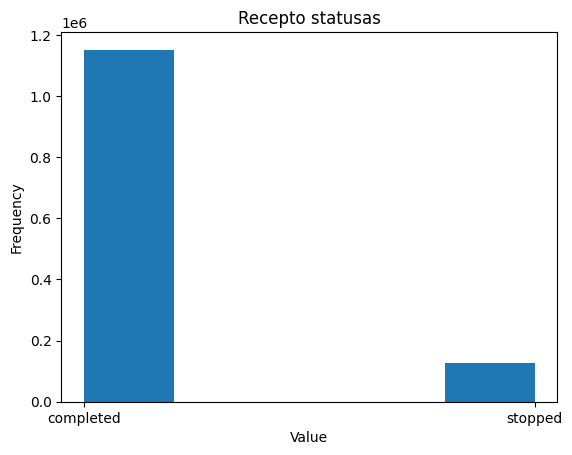

completed    90.031529
stopped       9.968471
Name: recepto_statusas, dtype: float64


In [42]:
stats = df['recepto_statusas'].value_counts()
print(stats)

plt.hist(df['recepto_statusas'], bins=5)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Recepto statusas')
plt.show()

print(stats/len(df) * 100)

- siekiant issaugoti pradini duomenu rinkini, sukuriama kopija 

In [43]:
df_copy = df.copy()

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278842 entries, 0 to 1300576
Data columns (total 14 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   ligos_kodas                 1278842 non-null  object 
 1   vaisto_tipas                1278842 non-null  object 
 2   vaisto_bendr_pav            1278842 non-null  object 
 3   vaisto_stiprumas            1278842 non-null  object 
 4   dozuociu_sk                 1278842 non-null  int64  
 5   vart_trukme_d               1278842 non-null  int64  
 6   recepto_galiojimas_d        1278842 non-null  int64  
 7   kompens_poz                 1278842 non-null  int64  
 8   recepto_statusas            1278842 non-null  object 
 9   gyd_kvalifikacijos_galioja  1278842 non-null  object 
 10  pac_lytis                   1278842 non-null  object 
 11  pac_amziaus_gr              1278842 non-null  object 
 12  pac_savivaldybe             1278842 non-null  object 
 1

- Vėliau koduojant ir paduodant modeliui mokytis duomenis susidurta su memory problema - tiek daug skirtingu stulpeliu variaciju išanalizuoti pritruko resursų - nuspresta atsisakyti daugiausiai unikaliu reiksmių turinčio labai svarbaus analizei stulpelio apie ligos kodus. 

- ligos kodas turi virš 3000 unikalių reikšmių 

- Siekiaint išsaugoti kuo imanomą daugiau reišmingos informacijos, iš ligos kodo raidžių ir skaičių kombinacijos buvo atkirtos ligos kodo raidės, nurodančios ligos popudį (pvz:I - širdies ligos, F - psichikos sveikatos sutrikimai ir t.t.)

- ligos kodo raidės buvo perkeltos į naują stulpelį pavadinimu "liga"

In [49]:
df['ligos_kodas'].nunique() 

3678

In [50]:
df['liga'] = df['ligos_kodas'].str.extract(r'^([A-Za-z]+)')
df.head()

,ligos_kodas,vaisto_tipas,vaisto_bendr_pav,vaisto_stiprumas,dozuociu_sk,vart_trukme_d,recepto_galiojimas_d,kompens_poz,recepto_statusas,gyd_kvalifikacijos_galioja,pac_lytis,pac_amziaus_gr,pac_savivaldybe,pardavimai,liga
0,I11.9,Vaistas,tert-butilamino perindoprilis/Indapamidas,"8 mg/2,5 mg",60,60,29,1,completed,"Medicinos gydytojas, Šeimos gydytojas",M,Nuo 65 m.,Kauno m. sav.,13413.0,I
1,J42,Vaistas,Azitromicinas,500 mg,3,3,29,0,completed,Šeimos gydytojas,M,Nuo 65 m.,Zarasų r. sav.,8741.0,J
2,I11.9,Vaistas,Telmisartanas/Hidrochlorotiazidas,"80 mg/12,5 mg",28,28,9,1,stopped,Gydytojas kardiologas,M,45-64 m.,Klaipėdos m. sav.,5703.0,I
3,I11.0,Vaistas,Bizoprololis/Amlodipinas,5 mg/5 mg,60,60,29,1,completed,Šeimos gydytojas,M,Nuo 65 m.,Klaipėdos m. sav.,18218.0,I
4,I11.9,Vaistas,tert-butilamino perindoprilis/Amlodipinas,8 mg/10 mg,90,90,29,1,completed,Šeimos gydytojas,M,Nuo 65 m.,Jonavos r. sav.,9154.0,I


In [51]:
df['liga'].nunique() 

24

- Dirbant toliau susidurta su ta pačia problema - užkoduoto duomenų stulpelių skaičiaus nebuvo imanoma apmokyti del atminties stokos
- išnagrinėta, kurie stulpeliai turi daugaiusiai unikalių reikšmių ir jų buvo tekta atsisakyti 

In [52]:
df.nunique()

ligos_kodas                   3678
vaisto_tipas                     3
vaisto_bendr_pav              1048
vaisto_stiprumas               905
dozuociu_sk                    473
vart_trukme_d                  208
recepto_galiojimas_d           115
kompens_poz                      2
recepto_statusas                 2
gyd_kvalifikacijos_galioja     107
pac_lytis                        2
pac_amziaus_gr                   4
pac_savivaldybe                 61
pardavimai                     843
liga                            24
dtype: int64

- Blogiausia dalis - tekta atisakyti stulpelių apie vaisto pavadinima ir stipruma. 
- Bandyta apskaičiuoti, gal vaistų pavadinimai ryškiai skiraisi pagal pasikartojima duomenyse, tačiau matoma, kad nei vienas vaistas neišsiskyre populiarumu  

In [53]:
value_counts = df['vaisto_bendr_pav'].value_counts()

print(value_counts.head(10)/1278842*100)

Metoprololio sukcinatas            2.889802
Nebivololis                        2.455034
Atorvastatinas                     2.337662
Metformino hidrochloridas          2.176031
Bromazepamas                       2.166413
Rozuvastatinas                     1.975381
Amoksicilinas                      1.728048
Levotiroksino natrio druska        1.645317
Amoksicilinas/Klavulano rūgštis    1.480558
Kvetiapinas                        1.410104
Name: vaisto_bendr_pav, dtype: float64


In [54]:
df.isna().sum()

ligos_kodas                   0
vaisto_tipas                  0
vaisto_bendr_pav              0
vaisto_stiprumas              0
dozuociu_sk                   0
vart_trukme_d                 0
recepto_galiojimas_d          0
kompens_poz                   0
recepto_statusas              0
gyd_kvalifikacijos_galioja    0
pac_lytis                     0
pac_amziaus_gr                0
pac_savivaldybe               0
pardavimai                    0
liga                          0
dtype: int64

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278842 entries, 0 to 1300576
Data columns (total 15 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   ligos_kodas                 1278842 non-null  object 
 1   vaisto_tipas                1278842 non-null  object 
 2   vaisto_bendr_pav            1278842 non-null  object 
 3   vaisto_stiprumas            1278842 non-null  object 
 4   dozuociu_sk                 1278842 non-null  int64  
 5   vart_trukme_d               1278842 non-null  int64  
 6   recepto_galiojimas_d        1278842 non-null  int64  
 7   kompens_poz                 1278842 non-null  int64  
 8   recepto_statusas            1278842 non-null  object 
 9   gyd_kvalifikacijos_galioja  1278842 non-null  object 
 10  pac_lytis                   1278842 non-null  object 
 11  pac_amziaus_gr              1278842 non-null  object 
 12  pac_savivaldybe             1278842 non-null  object 
 1

In [56]:
df_copy = df.copy()

- Pagal informacija, zinoma, kad duomenu rinkinyje abstu kategoriniu stulpeliu. 
- Pries kuriant modelį, turime isitikinti, kad visi šie duomenys butų tvarkingai užkoduoti. 
- Taupant kompiuterio atmintį, atrinkti modeliui naudoti kategoriniai stulpeliai išvardinti df_categorical 
- Visi buve duomenyse numeric stulpeliai buvo naudoti
- target stulpelis - recepto statusas 
- koduojant duomenis buvo naudotas One Code Encoderio get dummies funkcija 

In [57]:
df_categorical  = df[['liga', 'vaisto_tipas','gyd_kvalifikacijos_galioja', 'pac_lytis','pac_amziaus_gr']]
df_numeric  = df[['dozuociu_sk', 'vart_trukme_d', 'recepto_galiojimas_d', 'kompens_poz']]
target  = df['recepto_statusas']

encoder = OneHotEncoder()
encoded_categorical = pd.get_dummies(df_categorical, sparse=False)

encoded_categorical


,liga_A,liga_B,liga_C,liga_D,liga_E,liga_F,liga_G,liga_H,liga_I,liga_J,...,"gyd_kvalifikacijos_galioja_Vaikų ligų gydytojas, Šeimos gydytojas",gyd_kvalifikacijos_galioja_Vidaus ligų gydytojas,"gyd_kvalifikacijos_galioja_Vidaus ligų gydytojas, Šeimos gydytojas",gyd_kvalifikacijos_galioja_Šeimos gydytojas,pac_lytis_M,pac_lytis_V,pac_amziaus_gr_18-44 m.,pac_amziaus_gr_45-64 m.,pac_amziaus_gr_Iki 17 m.,pac_amziaus_gr_Nuo 65 m.
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300572,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
1300573,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
1300574,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1300575,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [58]:
target

0          completed
1          completed
2            stopped
3          completed
4          completed
             ...    
1300572    completed
1300573    completed
1300574    completed
1300575    completed
1300576    completed
Name: recepto_statusas, Length: 1278842, dtype: object

In [59]:
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df_numeric)

scaled_numeric

array([[-0.00159602,  0.16399527, -0.03356609,  0.84178193],
       [-0.00651035, -1.18263032, -0.03356609, -1.18795613],
       [-0.00435494, -0.59200506, -1.44032572,  0.84178193],
       ...,
       [-0.00159602,  0.16399527, -0.03356609,  0.84178193],
       [-0.00556197, -1.08813028, -0.10390407, -1.18795613],
       [-0.00556197, -1.08813028, -0.03356609, -1.18795613]])

In [60]:
df_scaled = pd.DataFrame(scaled_numeric, columns=df_numeric.columns)
df_scaled.head()

,dozuociu_sk,vart_trukme_d,recepto_galiojimas_d,kompens_poz
0,-0.001596,0.163995,-0.033566,0.841782
1,-0.006510,-1.182630,-0.033566,-1.187956
2,-0.004355,-0.592005,-1.440326,0.841782
3,-0.001596,0.163995,-0.033566,0.841782
4,0.000990,0.872746,-0.033566,0.841782


In [61]:
encoded_categorical.reset_index(drop=True, inplace=True)
df_scaled.reset_index(drop=True, inplace=True)

In [62]:
encoded_df = pd.concat([encoded_categorical, df_scaled], axis=1)

In [63]:
encoded_df

,liga_A,liga_B,liga_C,liga_D,liga_E,liga_F,liga_G,liga_H,liga_I,liga_J,...,pac_lytis_M,pac_lytis_V,pac_amziaus_gr_18-44 m.,pac_amziaus_gr_45-64 m.,pac_amziaus_gr_Iki 17 m.,pac_amziaus_gr_Nuo 65 m.,dozuociu_sk,vart_trukme_d,recepto_galiojimas_d,kompens_poz
0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,-0.001596,0.163995,-0.033566,0.841782
1,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,-0.006510,-1.182630,-0.033566,-1.187956
2,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,-0.004355,-0.592005,-1.440326,0.841782
3,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,-0.001596,0.163995,-0.033566,0.841782
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0.000990,0.872746,-0.033566,0.841782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278837,0,0,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,-0.001596,1.581496,-0.033566,0.841782
1278838,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0.003577,0.163995,-0.033566,0.841782
1278839,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,-0.001596,0.163995,-0.033566,0.841782
1278840,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,-0.005562,-1.088130,-0.103904,-1.187956


In [64]:
encoded_target = pd.get_dummies(target, sparse=False)

encoded_target

,completed,stopped
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0
...,...,...
1300572,1,0
1300573,1,0
1300574,1,0
1300575,1,0


- Siekiant patikrinti rysius tarp kintamuju, ir uzkirsti kelia multikolinearumui, issikvieciame koreliacijos matrica. Matomi rezultatai rodo, jog labiausiai susije rysiai yra tarp vartojimo trukmes ir vaistu kompensacijos.

C:\Users\mazei\AppData\Local\Temp\ipykernel_20788\2342645466.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


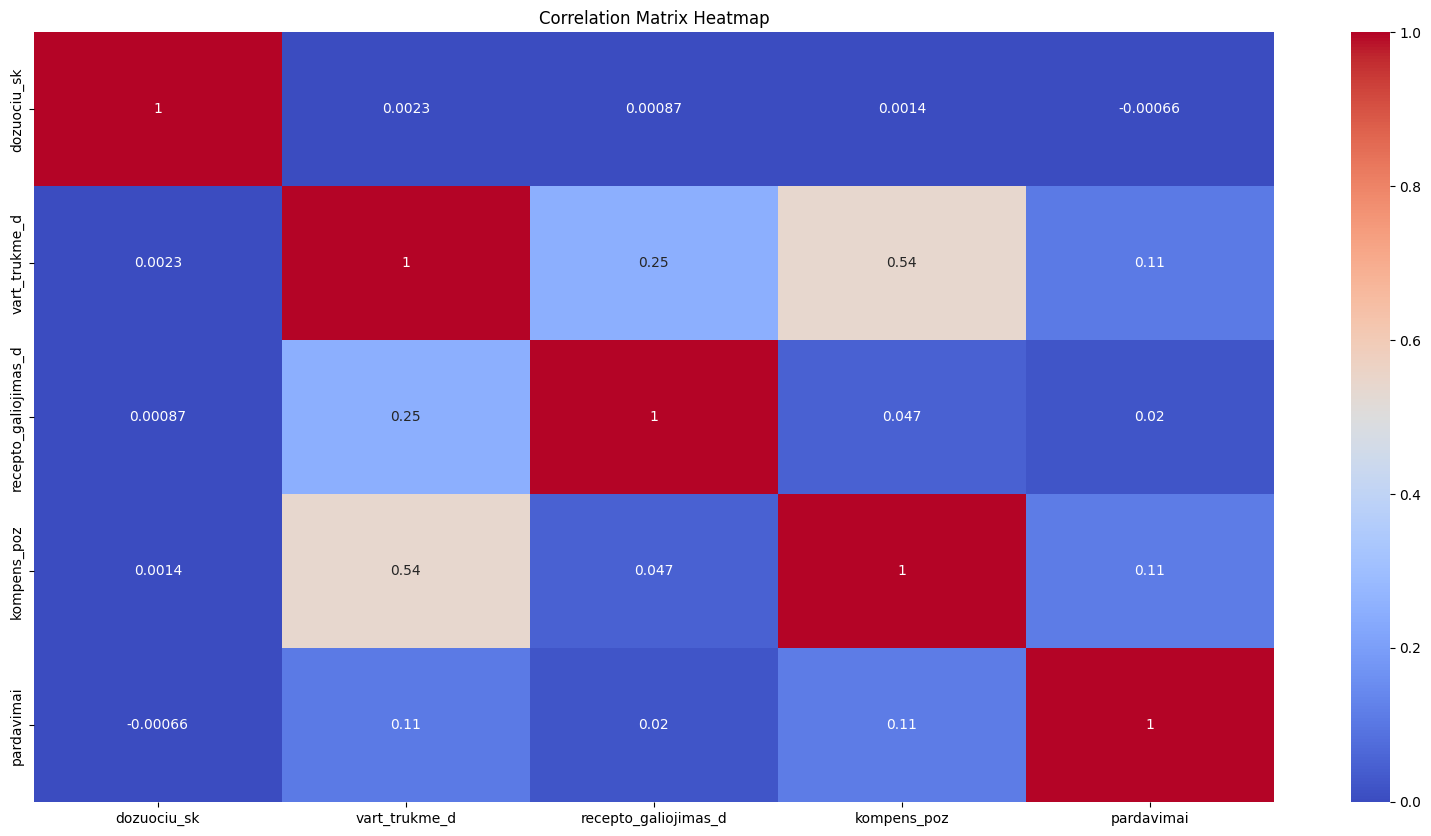

In [66]:
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(20,10))# Compute the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

- Po visu duomenu valymo žingsnių, duomenys padalinami i training ir testing duomenis pagal target variable. Training data dydis - 80%, testing data dydis - 20% viso duomenu rinkinio 

In [67]:
X_train, X_test, y_train, y_test = train_test_split(encoded_df, encoded_target, test_size=0.2, random_state=42)

- Pirmasis modelis -  XGBoost (eXtreme Gradient Boosting) algoritmas, jis sujungia kelis silpnesnius modelius (dazniausiai decision tree) ir panaudoja juos kuriant viena galinga asambliuota modelį. 
 - Naudoti hyperparametrai atspindintys geriausius rezultatus - maximalus gylis - 10, augimo politika - lossguide, sakanti kad augimas vyktu su didžiausiu losso sumažinimu.
 - kadangi žinoma, kad mūsų klasės nėra subalansuotos, naudotas scale_post_weight=10 sakantis, kad mažoji klasė yra 10 kartų mažesnė nei didžioji klasė


In [48]:
pipeline_XGB = make_pipeline(
    XGBClassifier(max_depth= 10, grow_policy='lossguide',
                  eta=0.5, gama='min_split_loss', 
                  sampling_method= 'gradient_based',
                  scale_pos_weight=10, n_jobs=-1))


pipeline_XGB.fit(X_train, y_train)


y_pred_XGB = pipeline_XGB.predict(X_test)


print(classification_report(y_test, y_pred_XGB))

[15:24:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gama" } are not used.

              precision    recall  f1-score   support

           0       0.90      1.00      0.95    230232
           1       0.19      0.64      0.30     25537

   micro avg       0.72      0.96      0.83    255769
   macro avg       0.55      0.82      0.62    255769
weighted avg       0.83      0.96      0.88    255769
 samples avg       0.80      0.96      0.85    255769



C:\Users\mazei\PycharmProjects\ML2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rezultatai : nors ir duomenys buvo scalinti, pirmają klase, kas yra neisigyti receptai, modeliui atpažinti buvo sunku. Modelis 64 procentus neisigytų receptų atpazino teisingai. 

- Antras modelis buvo Voting Classifier - 'rankinis' ansambliavimo budas, kai iš trijų skirtingų sckit learno modeliu, balsavimo budu buvo atrinktas ir pateiktas geriausias modelis. 

Naudoti modeliai: 

- Random forest 
- Logistine regresija 
- Gaussian Naive Bayes


In [68]:
y_train = y_train.iloc[:, 0]
y_test = y_test.iloc[:, 0]


In [77]:
model1 = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', n_jobs=-1)
model2 = LogisticRegression()
model3 = GaussianNB()


pipeline_vc = make_pipeline(
    VotingClassifier(
        estimators=[('model1', model1), ('model2', model2), ('model3', model3)],
        voting='hard'
    )
)


pipeline_vc.fit(X_train, y_train)


y_pred_vc = pipeline_vc.predict(X_test)


print(classification_report(y_test, y_pred_vc))

C:\Users\mazei\PycharmProjects\ML2\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.21      0.25      0.23     25537
           1       0.92      0.90      0.91    230232

    accuracy                           0.83    255769
   macro avg       0.56      0.57      0.57    255769
weighted avg       0.85      0.83      0.84    255769



Rezultatai: Voting classifierio rezultatai siek tiek geresni nei XGB classifierio atpažįstant neisigytu receptų klase, tačiau isigytų receptų atpažino tik 25 procentus. Pats modelio accuracy isliko toks pat - 83 procentai 

# Antras Bandymas 

- pamacius kad aproksimacijos pridejus pardavimu kieki pagal vaisto pavadinima nedave jokiu geru rezultatu, pabandykime padaryti modeli kaip featurus naudojant tik pardavimus ir ligos pavadinimą. target - recepto statusas

- naudotas XGB ir Voting classifieriai rezultatu palyginimui

Naudojama ant dataframe'o kopijos, ismetant visus irrelavant stulpalius 

In [69]:
df_copy1 = df_copy.copy().drop(['recepto_galiojimas_d','pac_lytis', 'vaisto_tipas', 'vaisto_bendr_pav', 'vaisto_stiprumas', 'dozuociu_sk','kompens_poz', 'gyd_kvalifikacijos_galioja','pac_amziaus_gr','pac_savivaldybe'], axis=1)

In [70]:
df_copy1 = df_copy1.drop(['vart_trukme_d'],axis=1)

In [71]:
df_copy1.head()

,ligos_kodas,recepto_statusas,pardavimai,liga
0,I11.9,completed,13413.0,I
1,J42,completed,8741.0,J
2,I11.9,stopped,5703.0,I
3,I11.0,completed,18218.0,I
4,I11.9,completed,9154.0,I


- iš naujo užsikoduojami ir sujungiami kintamieji 

In [73]:
encoder = OneHotEncoder()
encoded_target = pd.get_dummies(df['recepto_statusas'], sparse=False)
encoded_liga = pd.get_dummies(df['liga'], sparse=False)

numeric = df['pardavimai']
numeric_reshaped = numeric.values.reshape(-1, 1)

numeric

scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(numeric_reshaped)
df_scaled = pd.DataFrame(scaled_numeric, columns=['pardavimai'])
encoded_liga
encoded_liga.reset_index(drop=True, inplace=True)
encoded_liga

encoded_df = pd.concat([encoded_liga, df_scaled], axis=1)

encoded_df


,A,B,C,D,E,F,G,H,I,J,...,P,Q,R,S,T,U,W,Y,Z,pardavimai
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.451637
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-0.590487
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.680774
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.308835
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.578212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278837,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.412288
1278838,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.048908
1278839,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.311480
1278840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.085425


- train test splito dydis - toks pat 

In [74]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df_scaled, encoded_target, test_size=0.2, random_state=42)

XGB classifierio modelis naudojamas tas pats - pipeline'as pritaikytas naujiems training ir testing splitams 

In [128]:
pipeline_XGB.fit(X1_train, y1_train)


y_pred_XGB1 = pipeline_XGB.predict(X1_test)

# Print the classification report
print(classification_report(y1_test, y_pred_XGB1))


[09:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gama" } are not used.

              precision    recall  f1-score   support

           0       0.50      0.00      0.00     25537
           1       0.90      1.00      0.95    230232

    accuracy                           0.90    255769
   macro avg       0.70      0.50      0.47    255769
weighted avg       0.86      0.90      0.85    255769



Rezultatai : rezultatai smarkiai blogesni nei pirmojo modelio - isigytu receptu klases absoliučiai neidentifikuoja, tačiau gali tiksliai pasakyti kurie receptai nėra isigyti. modelio accuracy geriausias is visu - 90 porcentų

- tie patys žingsniai buvo naudoti ir su Voting classifieriu - padarytas pipeline'as buvo pritaikytas naujiems training ir testing splitams 

In [80]:
y1_train = y1_train.iloc[:, 0]
y1_test = y1_test.iloc[:, 0]

pipeline_vc.fit(X1_train, y1_train)


y_pred_vc1 = pipeline_vc.predict(X1_test)


print(classification_report(y1_test, y_pred_vc1))

              precision    recall  f1-score   support

           0       0.19      0.01      0.01     25537
           1       0.90      1.00      0.95    230232

    accuracy                           0.90    255769
   macro avg       0.54      0.50      0.48    255769
weighted avg       0.83      0.90      0.85    255769



Rezultatai: accuracy ir galutinis rezultatas beveik identiškas pirmajam modeliui pirmosios klases atzvilgiu. Nulinės klasės precisionas prastesnis 31 procentu. 

# Išvados

Turint omenyje, kad buvo išmesti ir nenaudoti trečdalis stulpelių dėl duomenų trūkumo, ir pagrindiniai stulpeliai turintys informacija apie patį vaistą, modeliai gali visai neblogai spelioti ar receptas nebus isigytas. Mano manymu, tai buvo pagrindinė bėda tolimesniam ir geresniam modelių tobulinimui. 